# Learning Cost Function for Optimal Transport

From https://arxiv.org/pdf/2002.09650.pdf

In [137]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
from typing import Callable
from rich.progress import track

from floOTflix.models import MFModel
from floOTflix.utils import check_k_last_increasing

# Generate Toy Dataset

To build a toy dataset, we create $r \in R^m$ and $c \in R^n$ two random marginal distribution and let $C_{truth} \in [0, 1]^{m,n}$ be a random cost matrix.

In [18]:
p = 1
m, n = 5, 5
k = 2

# create random marginal distributions
r = 1 + torch.rand(m)
c = 1 + torch.rand(n)

r /= torch.sum(r)
c /= torch.sum(c)

# create random cost matrix
U_truth = torch.rand(m, k)
V_truth = torch.rand(n, k)
A_truth = torch.rand(k, k)

C_truth = U_truth @ A_truth @ V_truth.t()

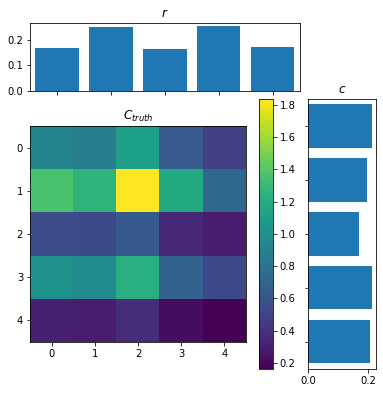

In [19]:
# from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,
    width_ratios=(4, 1), height_ratios=(1, 4), left=0.1,
    right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)


sp = ax.imshow(C_truth)
fig.colorbar(sp, ax=ax)
ax.set_title('$C_{truth}$')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.bar(np.arange(m), r)
ax_histx.set_title('$r$')

ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.barh(np.arange(n), c)
ax_histy.set_title('$c$')

plt.show()

In [20]:
eps = 1e-1
pi_sample = ot.sinkhorn(r, c, C_truth, reg=eps, numItermax=100_000)

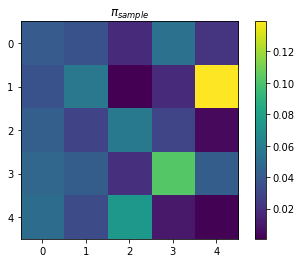

Min=0.0008362142252735794, Max=0.1390657275915146, Sum=1.0


In [21]:
sp = plt.imshow(pi_sample)
plt.title('$\pi_{sample}$')
plt.colorbar()
plt.show()

pi_min = pi_sample.min()
pi_max = pi_sample.max()

print(f"Min={pi_min}, Max={pi_max}, Sum={pi_sample.sum()}")

# Tools

In [132]:
def get_loss(C):
    return ((C - C_truth)**2).sum().item()

# CLIDIOT (Cost Learning in Discrete Inverse OT) Algorithm


In [174]:

def CLIDIOT(pi_sample, prox_fn: Callable[[torch.TensorType], torch.TensorType], c_init, alpha_init, beta_init, eps=1e-1, max_iter=100, num_eps=1e-6):
    m, n = pi_sample.shape
    mu, nu = pi_sample@torch.ones(m), pi_sample.t()@torch.ones(n)
    c, alpha, beta = c_init, alpha_init, beta_init
    u, v = torch.exp(alpha / eps), torch.exp(beta / eps)
    losses = []
    for i in range(max_iter):
        K = torch.exp(-c / eps)
        u = mu / (K@v + num_eps)
        v = nu / (K.t()@u + num_eps)
        K = pi_sample / (torch.outer(u, v.t()) + num_eps)
        # K = pi_sample / (u@v.t() + num_eps)
        c = prox_fn(-eps * torch.log(K + num_eps))
        loss = get_loss(c)
        losses.append(loss)

        print(f"loss[{i}]: {loss}")
        if check_k_last_increasing(losses, 5):
            print("Early Stopping.")
            break
    return c

In [175]:
def plot_c_pred(C_pred):
    C_pred = C_pred.detach().numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(C_truth)
    ax1.set_title('$C_{truth}$')
    ax2.imshow(C_pred)
    ax2.set_title('$C_{pred}$')
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(sp, cax=cbar_ax)
    plt.show()

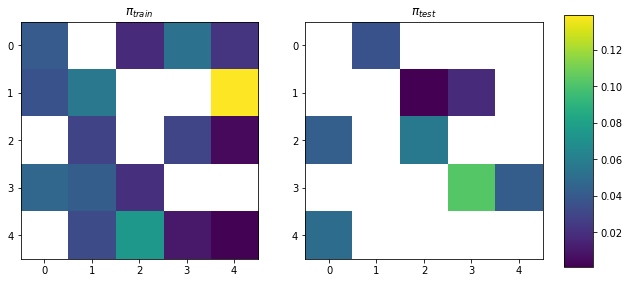

In [189]:
N = m * n
N_train = int(.7 * N)

train_index = np.random.choice(N, N_train, replace=False)
test_index = np.setdiff1d(np.arange(N), train_index)

train_index = np.unravel_index(train_index, (m, n))
test_index = np.unravel_index(test_index, (m, n))

X_train = torch.from_numpy(np.array(train_index).T)
y_train = pi_sample[train_index]
pi_train = pi_sample.clone()
pi_train[test_index] = np.nan

X_test = torch.from_numpy(np.array(test_index).T)
y_test = pi_sample[test_index]
pi_test = pi_sample.clone()
pi_test[train_index] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(pi_train, vmin=pi_min, vmax=pi_max)
ax1.set_title('$\pi_{train}$')
ax2.imshow(pi_test, vmin=pi_min, vmax=pi_max)
ax2.set_title('$\pi_{test}$')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(sp, cax=cbar_ax)
plt.show()

In [190]:
mf_model = MFModel(m, n, k)
mf_model.fit(X_train, y_train, X_test, y_test, n_epochs=1000)

U, V = mf_model.U, mf_model.V
print(f'U: {U.shape} V: {V.shape}')

score = mf_model.score(X_test, y_test)
print(f"MFModel score: {score}")

Output()

[14:06:05] Epoch 0, train error: 0.2656135559082031, test error: 0.2822597920894623                       ]8;id=410233;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=337685;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 100, train error: 0.10055935382843018, test error: 0.11746033281087875                   ]8;id=633935;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=557188;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[14:06:06] Epoch 200, train error: 0.0381368026137352, test error: 0.05106022208929062                    ]8;id=856746;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=750683;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Epoch 300, train error: 0.02578369714319706, test error: 0.03776993229985237                   ]8;id=818622;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=917603;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

           Early stopping                                                                                 ]8;id=23939;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=311203;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#125\125]8;;\

U: torch.Size([5, 2]) V: torch.Size([5, 2])
MFModel score: 0.03754692152142525


In [193]:
U = U.detach()
V = V.detach()
# U = torch.rand(m, k)
# V = torch.rand(n, k)


max_iter_prox = 100
gamma = 5
eps = .1
max_iter = 1000

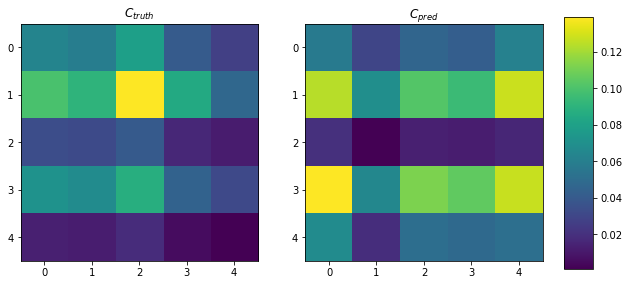

Init. loss: 17.219938278198242
loss[0]: 15.833868026733398
loss[1]: 14.937235832214355
loss[2]: 14.085887908935547
loss[3]: 13.280834197998047
loss[4]: 12.522027969360352
loss[5]: 11.809005737304688
loss[6]: 11.140777587890625
loss[7]: 10.51660442352295
loss[8]: 9.935297012329102
loss[9]: 9.395537376403809
loss[10]: 8.896080017089844
loss[11]: 8.43543529510498
loss[12]: 8.012032508850098
loss[13]: 7.6243062019348145
loss[14]: 7.270665645599365
loss[15]: 6.94960880279541
loss[16]: 6.659374237060547
loss[17]: 6.398273468017578
loss[18]: 6.164570331573486
loss[19]: 5.956662178039551
loss[20]: 5.772877216339111
loss[21]: 5.61152982711792
loss[22]: 5.470919609069824
loss[23]: 5.349425792694092
loss[24]: 5.245336532592773
loss[25]: 5.156901836395264
loss[26]: 5.082337379455566
loss[27]: 5.0199432373046875
loss[28]: 4.967937469482422
loss[29]: 4.924590110778809
loss[30]: 4.888250827789307
loss[31]: 4.857357025146484
loss[32]: 4.830569744110107
loss[33]: 4.806694030761719
loss[34]: 4.784797668

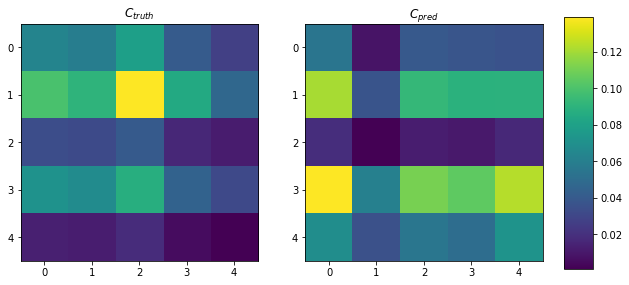

In [195]:

U_inv = torch.linalg.pinv(U)
V_inv = torch.linalg.pinv(V)

A_init = torch.rand(k, k)
c_init = U @ A_init @ V.t()

plot_c_pred(c_init)
print(f"Init. loss: {get_loss(c_init)}")

alpha_init = torch.rand(U.shape[0])
beta_init = torch.rand(V.shape[0])

def prox_fn(C):
    A_truth = U_inv @ C @ V_inv.t()
    A = torch.nn.Parameter(A_truth.clone())
    opt = torch.optim.Adam([A])
    for i in range(max_iter_prox):
        loss = gamma * 1/2 * torch.norm(A - A_truth) + 1/2 * torch.norm(A)
        opt.zero_grad()
        loss.backward()
        opt.step()
    A = A.detach()
    return U @ A @ V.t()

C_pred = CLIDIOT(pi_sample, prox_fn=prox_fn, c_init=c_init, alpha_init=alpha_init, beta_init=beta_init, eps=eps, max_iter=max_iter)

plot_c_pred(C_pred)

In [183]:
pi_pred = ot.sinkhorn(r, c, C_pred, reg=eps, numItermax=100_000)

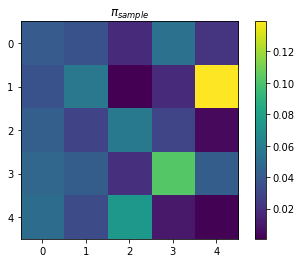

Min=0.0008362142252735794, Max=0.1390657275915146, Sum=1.0


In [184]:
sp = plt.imshow(pi_sample)
plt.title('$\pi_{sample}$')
plt.colorbar()
plt.show()

pi_min = pi_sample.min()
pi_max = pi_sample.max()

print(f"Min={pi_min}, Max={pi_max}, Sum={pi_sample.sum()}")